#Import the necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imutils

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import tensorflow as tf

In [ ]:

from PIL import Image
from imutils import paths

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from math import ceil


#CONVERING EACH FOLDER INTO ARRAY SEPARATELY

In [ ]:
# making n X m matrix


cov_imgs = [fn for fn in os.listdir('/content/drive/My Drive/datasets/COVID-19') if fn.endswith('.png')]
normal_imgs = [fn for fn in os.listdir('/content/drive/My Drive/datasets/NORMAL') if fn.endswith('.png')]
pneumo_imgs = [fn for fn in os.listdir('/content/drive/My Drive/datasets/Viral Pneumonia') if fn.endswith('.png')]

def img2np(path, list_of_filename, size = (256, 256)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders

covid_images = img2np('/content/drive/My Drive/datasets/COVID-19/', cov_imgs)
normal_images = img2np('/content/drive/My Drive/datasets/NORMAL/', normal_imgs)
pnemonia_images = img2np('/content/drive/My Drive/datasets/Viral Pneumonia/', pneumo_imgs)


#**EXPLORATORY DATA ANALYSIS**

#Printing random images

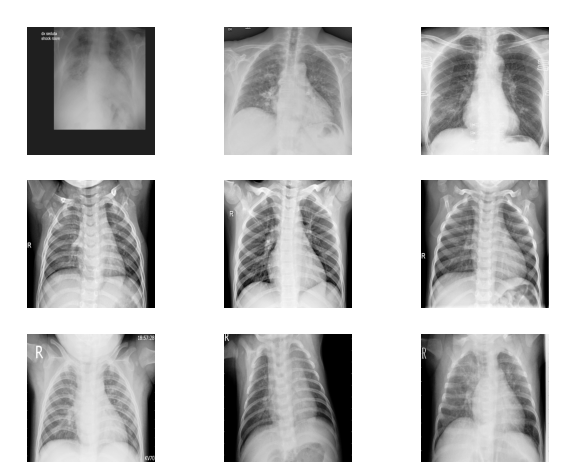

In [ ]:
#train_dir = 'DATA/train' # image folder
 


# randomly select 3 of each
select_cov = np.random.choice(cov_imgs, 3, replace = False)
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (10,8))
for i in range(9):
    if i < 3:
        fp = f'/content/drive/My Drive/datasets/COVID-19/{select_cov[i]}'
        label = 'COVID-19'
    elif i < 6:
        fp = f'/content/drive/My Drive/datasets/NORMAL/{select_norm[i-3]}'
        label = 'NORMAL'
    else:
        fp = f'/content/drive/My Drive/datasets/Viral Pneumonia/{select_pneu[i-6]}'
        label = 'VIRAL PNEUMONIA'
    ax = fig.add_subplot(3, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label, fontsize = 18, color = "white")
    plt.axis('off')
plt.show()

#Printing average images

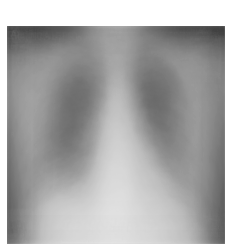

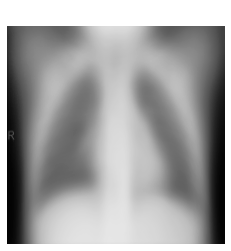

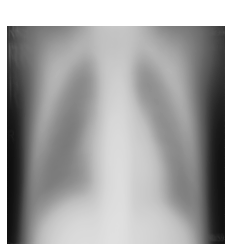

In [ ]:


def find_mean_img(full_mat, title, size = (256, 256)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'{title}', fontsize = 18, color = "white")
    plt.axis('off')
    plt.show()
    return mean_img

cov_mean = find_mean_img(covid_images, 'COVID-19')
norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'VIRAL PNEUMONIA')


#Printing contrast images 

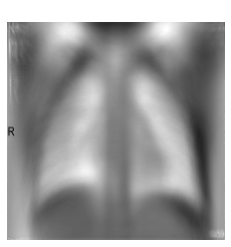

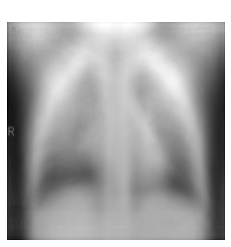

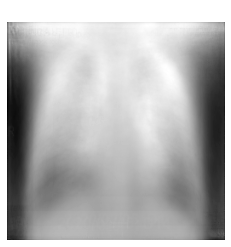

In [ ]:


contrast_1mean = norm_mean - pneu_mean
plt.imshow(contrast_1mean, cmap='gray_r')
plt.title(" ")
plt.axis('off')
plt.show()

contrast_2mean = cov_mean - norm_mean
plt.imshow(contrast_2mean, cmap='gray_r')
plt.title(" ")
plt.axis('off')
plt.show()

contrast_3mean = cov_mean - pneu_mean
plt.imshow(contrast_3mean, cmap='gray_r')
plt.title(" ")
plt.axis('off')
plt.show()

#Printing standrad deviation images

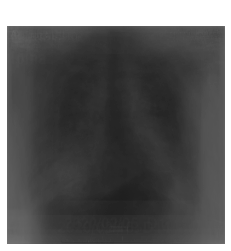

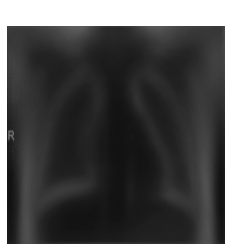

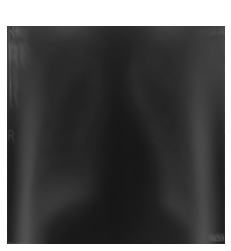

In [ ]:
def find_std_img(full_mat, title, size = (256, 256)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'{title}', fontsize = 18, color = 'white')
    plt.axis('off')
    plt.show()
    return std_img

cov_std = find_std_img(covid_images, 'COVID-19')
norm_std = find_std_img(normal_images, 'NORMAL')
pneu_std = find_std_img(pnemonia_images, 'VIRAL PNEUMONIA')


#Loading the images to one folder

In [ ]:
image_size = 256

labels = ['COVID-19', 'NORMAL','Viral Pneumonia']

def create_training_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image), 0)
            image_resized = cv.resize(image_read,(image_size,image_size),cv.IMREAD_GRAYSCALE)/255.0
            images.append([image_resized,class_num])

    return np.array(images)
train = create_training_data('/content/drive/My Drive/datasets')
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)
    
X= np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(2904, 256, 256) (2904,)


In [ ]:
print(X.shape, y.shape)

(2904, 256, 256) (2904,)


#Number of images in each class

Number of Covid-19 images = 215
Number of Normal images = 1347
Number of Viral Pneumonia images = 1342


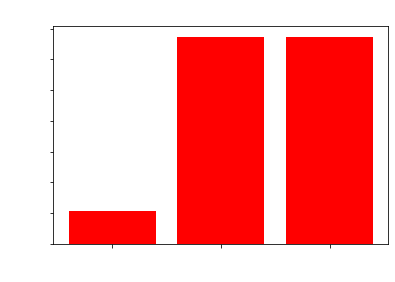

In [ ]:
xe = [i for i, _ in enumerate(labels)]

a = 0
b = 0
c = 0

for label in y:
    if label == 0:
        a += 1
    if label == 1:
        b += 1
    if label == 2:
        c += 1

print (f'Number of Covid-19 images = {a}')
print (f'Number of Normal images = {b}')
print (f'Number of Viral Pneumonia images = {c}')


numbers = [a,b,c]
plt.bar(xe,numbers,color = 'red')
plt.xlabel("Labels", fontsize = 10, color = "white")
plt.ylabel("No. of images", fontsize = 10, color = "white")
plt.title("Images for each class", fontsize = 18, color = "white")

plt.xticks(xe, labels, color = "white")
plt.yticks(color = "white")

plt.show()

#Train and test data split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 32, stratify=y)


#Number of images in test data

In [ ]:
d = 0
e = 0
f = 0

for label in y_test:
    if label == 0:
        d += 1
    if label == 1:
        e += 1
    if label == 2:
        f += 1
        
print (f'Number of Covid-19 images = {d}')
print (f'Number of Normal images = {e}')
print (f'Number of Viral Pneumonia images = {f}')

Number of Covid-19 images = 43
Number of Normal images = 270
Number of Viral Pneumonia images = 268


In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2323, 256, 256) (581, 256, 256)
(2323,) (581,)


#Number of images in each class of training data

Number of Covid-19 images = 172
Number of Normal images = 1077
Number of Viral Pneumonia images = 1074


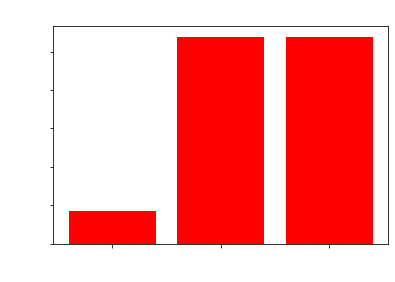

In [ ]:
# checking the number of images of each class

a = 0
b = 0
c = 0

for label in y_train:
    if label == 0:
        a += 1
    if label == 1:
        b += 1
    if label == 2:
        c += 1
        
print (f'Number of Covid-19 images = {a}')
print (f'Number of Normal images = {b}')
print (f'Number of Viral Pneumonia images = {c}')

# plotting the data

xe = [i for i, _ in enumerate(labels)]

numbers = [a,b,c]
plt.bar(xe,numbers,color = 'red')
plt.xlabel("Labels", fontsize = 10, color = "white")
plt.ylabel("No. of images", fontsize = 10, color = "white")
plt.title("Images for each class", fontsize = 18, color = "white")

plt.xticks(xe, labels, color = "white")
plt.yticks(color = "white")

plt.show()

In [ ]:
#check the difference from the majority class
difference_cov = b-a
difference_pne = b-c

print(difference_cov)
print(difference_pne)

905
3


#Data augmentation

In [ ]:
#Rotating images
def rotate_images(image, scale =1.0, h=256, w = 256):
    
    center = (h/2,w/2)
    
    angle = random.randint(-25,25)
    M = cv.getRotationMatrix2D(center, angle, scale)
    rotated = cv.warpAffine(image, M, (h,w))
    return rotated

#Flipping images
def flip (image):
    
    flipped = np.fliplr(image)
    return flipped

#Translating images
def translation (image):
    
    x= random.randint(-50,50)
    y = random.randint(-50,50)
    rows,cols = image.shape
    M = np.float32([[1,0,x],[0,1,y]])
    translate = cv.warpAffine(image,M,(cols,rows))
    
    return translate

#Apply Gaussian Blur to images
def blur (image):
    
    x = random.randrange(1,5,2)
    blur = cv.GaussianBlur(image,(x,x),cv.BORDER_DEFAULT)
    return blur

In [ ]:
def apply_aug (image):
    
    number = random.randint(1,4)
    
    if number == 1:
        image= rotate_images(image, scale =1.0, h=256, w = 256)
            
    if number == 2:
        image= flip(image)
                
    if number ==3:
        image= translation(image)
                
    if number == 4:
        image= blur(image)
    
    return image

In [ ]:
def oversample_images (difference_cov,difference_pne, X_train, y_train):
    
    cov_counter = 0
    pne_counter= 0
    new_cov = []
    new_pne = []
    label_cov = []
    label_pne = []
    
    for i,item in enumerate (X_train):
        
        if y_train[i] == 0 and cov_counter < difference_cov:
            co = 0
            for co in range(6):
              image = apply_aug(item)
              cov_counter = cov_counter + 1
              label = 0

              new_cov.append(image)
              label_cov.append(label)
            
        if y_train[i] == 2 and pne_counter < difference_pne:
            
            image = apply_aug(item)
            
            pne_counter = pne_counter+1
            label =2
            
            new_pne.append(image)
            label_pne.append(label)
            
    
    new_cov = np.array(new_cov)
    label_cov = np.array(label_cov)
    new_pne= np.array(new_pne)
    label_pne = np.array(label_pne)
    
    return new_cov, label_cov, new_pne, label_pne

In [ ]:
c_images,c_labels,p_images,p_labels =oversample_images(difference_cov,difference_pne,X_train,y_train)
print(c_images.shape)
print(c_labels.shape)
print(p_images.shape)
print(p_labels.shape)

(906, 256, 256)
(906,)
(3, 256, 256)
(3,)


#Plotting imgaes from the augmented images

Random artificially generated COVID-19 images


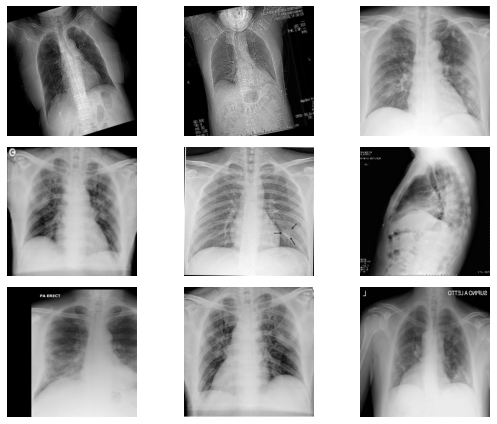

In [ ]:
# Extract 9 random images from the COVID-19 augmented images
print('Random artificially generated COVID-19 images')

# Adjust the size of your images
plt.figure(figsize=(8,6))

for i in range(9):
    num = random.randint(0,len(c_images)-1)
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(c_images[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Random artificially generated Viral Pneumonia images


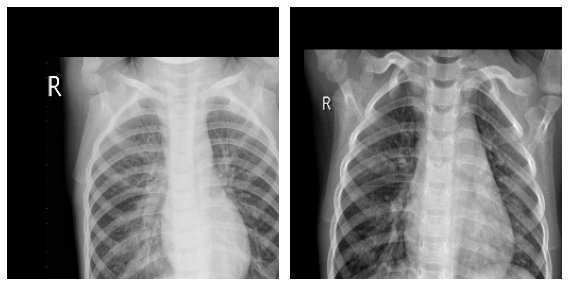

In [ ]:
# Displays 2 generated viral images 
# Extract 2 random images from the augmented Viral Pneumonia images
print('Random artificially generated Viral Pneumonia images')

# Adjust the size of your images
plt.figure(figsize=(8,6))

for i in range(2):
    num = random.randint(0,len(p_images)-1)
    plt.subplot(1, 2, i + 1)
    
    plt.imshow(p_images[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

#Integrating the artificially created images to the original training dataset

In [ ]:
new_labels = np.append(c_labels,p_labels)
y_new_labels = np.expand_dims(new_labels, axis=1)
x_new_images = np.append(c_images,p_images,axis=0)

X_train1 = np.append(X_train,x_new_images,axis=0)
y_train1 = np.append(y_train,y_new_labels)

print(X_train1.shape, X_test.shape)
print(y_train1.shape, y_test.shape)

(3232, 256, 256) (581, 256, 256)
(3232,) (581,)


Number of Covid-19 images = 1078
Number of Normal images =  1077
Number of Viral Pneumonia images = 1077


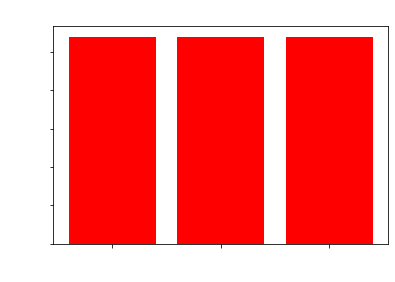

In [ ]:
nor_new=0
pne_new=0
cov_new =0

for i in y_train1:
    
    if i==0:
        cov_new = cov_new+1
    elif i==1 :
        nor_new = nor_new+1
    else:
        pne_new=pne_new+1    
        
print ('Number of Covid-19 images =',cov_new)
print ('Number of Normal images = ',nor_new)
print ('Number of Viral Pneumonia images =',pne_new)

# plotting the data

xe = [i for i, _ in enumerate(labels)]

numbers = [cov_new, nor_new, pne_new]
plt.bar(xe,numbers,color = 'red', )
plt.xlabel("Labels", fontsize = 10, color = 'white')
plt.ylabel("No. of images", fontsize = 10, color ="white")
plt.title("Images for each label", fontsize = 18, color = 'white')

plt.xticks(xe, labels, color = 'white')
plt.yticks(color = 'white')

plt.show()

In [ ]:

print(X_train1.shape, X_test.shape)
print(y_train1.shape, y_test.shape)

X_train1 = np.expand_dims(X_train1, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)
y_train1 = np.expand_dims(y_train1, axis = 1)
y_test = np.expand_dims(y_test, axis = 1)
print(X_train1.shape, X_test.shape,y_train1.shape, y_test.shape)
X_train1 = X_train1.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train1 = y_train1.astype(np.float32)
y_test = y_test.astype(np.float32)

print(X_train1.dtype)
print(y_train1.dtype)
print(X_test.dtype)
print(y_test.dtype)


(3232, 256, 256) (581, 256, 256)
(3232,) (581,)
(3232, 256, 256, 1) (581, 256, 256, 1) (3232, 1) (581, 1)
float32
float32
float32
float32


In [ ]:
print('Normalization')
print('Train',X_train1.min(), X_train1.max(), X_train1.mean(), X_train1.std())
print('Test', X_test.min(), X_test.max(), X_test.mean(), X_test.std())

Normalization
Train 0.0 1.0 0.48791924 0.25010774
Test 0.0 1.0 0.48859683 0.2478931


#CNN MODEL

In [ ]:

#works properly
from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32,3 ,3, input_shape = (256, 256, 1), activation="relu", padding='same'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size = (2,2), padding='same'))
model.add(Conv2D(32, 3, 3, activation = "relu", padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Conv2D(64, 3, 3, activation = "relu", padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Conv2D(64, 3, 3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Conv2D(64, 3, 3, activation="relu", padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding = "same"))
model.add(Conv2D(128, 3, 3, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Conv2D(128, 3, 3, activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2), padding = 'same'))
model.add(Conv2D(128, 3, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dense(512, activation = "relu"))
model.add(Dense(3, activation = "softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 86, 86, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0

#Training the model on the training dataset

In [ ]:
print(X_train1.shape,y_train1.shape, X_test.shape)

print("[INFO] training network...")
opt = Adam(lr=1e-3, decay=1e-3 / 50)
model.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["accuracy"])
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


H = model.fit(X_train1, y_train1, validation_data = (X_test, y_test), epochs=19, batch_size=32, callbacks=[cp_callback])
# evaluate the network


(3232, 256, 256, 1) (3232, 1) (581, 256, 256, 1)
[INFO] training network...
Epoch 1/19
101/101 [==============================] - ETA: 0s - loss: 0.8715 - accuracy: 0.5241
Epoch 00001: saving model to training_1/cp.ckpt
101/101 [==============================] - 26s 259ms/step - loss: 0.8715 - accuracy: 0.5241 - val_loss: 0.7317 - val_accuracy: 0.6282
Epoch 2/19
101/101 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7355
Epoch 00002: saving model to training_1/cp.ckpt
101/101 [==============================] - 26s 257ms/step - loss: 0.6038 - accuracy: 0.7355 - val_loss: 0.7014 - val_accuracy: 0.6833
Epoch 3/19
101/101 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.8376
Epoch 00003: saving model to training_1/cp.ckpt
101/101 [==============================] - 26s 255ms/step - loss: 0.4391 - accuracy: 0.8376 - val_loss: 0.4568 - val_accuracy: 0.8262
Epoch 4/19
101/101 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=32)
print(predictions)


[INFO] evaluating network...
[[3.3887755e-04 1.0064678e-03 9.9865460e-01]
 [6.3428949e-08 9.9996161e-01 3.8242928e-05]
 [9.9876153e-01 1.5549433e-04 1.0829306e-03]
 ...
 [4.0295639e-04 9.1827579e-04 9.9867874e-01]
 [8.6010044e-10 9.9999809e-01 1.9219572e-06]
 [3.1377639e-12 1.0000000e+00 3.9505672e-08]]


#Classification report

In [ ]:

np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test
class_labels = labels 
cm = confusion_matrix(y_test, predicted_classes)
print(cm)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


[[ 39   2   2]
 [  1 265   4]
 [  0  35 233]]
                 precision    recall  f1-score   support

       COVID-19       0.97      0.91      0.94        43
         NORMAL       0.88      0.98      0.93       270
Viral Pneumonia       0.97      0.87      0.92       268

       accuracy                           0.92       581
      macro avg       0.94      0.92      0.93       581
   weighted avg       0.93      0.92      0.92       581



In [ ]:
print(H.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#Accuracy plots

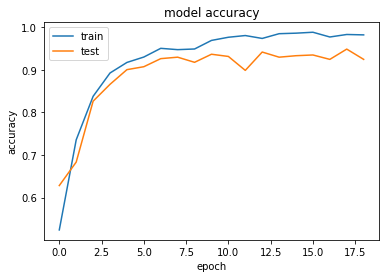

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Loss plots

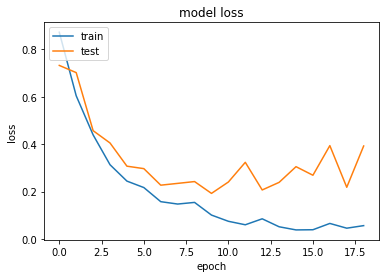

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Saving the model

In [ ]:
model.save('cov_pre_mod.h5')

#Centering

In [ ]:
'''
# center images
def prep_center(train, test):
	# convert from integers to floats
	train_cent = train.astype('float32')
	test_cent = test.astype('float32')
	# calculate statistics
	m = train_cent.mean()
	# center datasets
	train_cent = train_cent - m
	test_cent = test_cent - m
	# return normalized images
	return train_cent, test_cent
'''

In [ ]:
'''
# center
c_trainX, c_testX = prep_center(X_train1, X_test)
print('center')
print('Train', c_trainX.min(), c_trainX.max(), c_trainX.mean(), c_trainX.std())
print('Test', c_testX.min(), c_testX.max(), c_testX.mean(), c_testX.std())
'''

In [ ]:
'''
#CENTER MEAN IMAGES
print(X_train1.shape,y_train1.shape, X_test.shape)

print("[INFO] training network...")
#y_test = pd.Index(y_test)
#y_test = y_test.tolist()
opt = Adam(lr=1e-3, decay=1e-3 / 50)
#tf.convert_to_tensor(X_train)
#tf.convert_to_tensor(y_train)
#tf.convert_to_tensor(X_test)
model.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["accuracy"])
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#print(y_train1.shape)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#model.fit(c_trainX, y_train1, epochs=19, batch_size=128)
#H = model.fit(X_train, y_train, epochs=50, batch_size=32)
H = model.fit(c_trainX, y_train1, validation_data = (c_testX, y_test), epochs=19, batch_size=32, callbacks=[cp_callback])
# evaluate the network
'''

#Standardization

In [ ]:
'''
# standardize images
def prep_standardize(train, test):
	# convert from integers to floats
	train_stan = train.astype('float32')
	test_stan = test.astype('float32')
	# calculate statistics
	m = train_stan.mean()
	s = train_stan.std()
	# center datasets
	train_stan = (train_stan - m) / s
	test_stan = (test_stan - m) / s
	# return normalized images
	return train_stan, test_stan
  '''

In [ ]:
'''
#standardize
s_trainX, s_testX = prep_standardize(X_train1,X_test)
print('standardize')
print('Train',s_trainX.min(), s_trainX.max(), s_trainX.mean(), s_trainX.std())
print('Test', s_testX.min(), s_testX.max(), s_testX.mean(), s_testX.std())
'''

In [ ]:
'''
#STD IMAGES
print(X_train1.shape,y_train1.shape, X_test.shape)

print("[INFO] training network...")
#y_test = pd.Index(y_test)
#y_test = y_test.tolist()
opt = Adam(lr=1e-3, decay=1e-3 / 50)
#tf.convert_to_tensor(X_train)
#tf.convert_to_tensor(y_train)
#tf.convert_to_tensor(X_test)
model.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["accuracy"])
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#print(y_train1.shape)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#model.fit(c_trainX, y_train1, epochs=19, batch_size=128)
#H = model.fit(X_train, y_train, epochs=50, batch_size=32)
H = model.fit(s_trainX, y_train1, validation_data = (s_testX, y_test), epochs=19, batch_size=32, callbacks=[cp_callback])
# evaluate the network
'''

In [ ]:
'''
#long model,centre mean pred of the data and STD depnends on predictions
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test
class_labels = labels 
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
'''

In [ ]:
images2 = []
image2_read = cv.imread('/content/drive/MyDrive/pred data/COVID-19 (36).png', 0)
image2_resized = cv.resize(image2_read,(image_size,image_size),cv.IMREAD_GRAYSCALE)/255.0
#print(image_read, cv.IMREAD_GRAYSCALE)
images2.append(image2_resized)
#print(image_resized, class_num)
            

images2 = np.array(images2)

#images1 = images1.reshape( 1)
images2 = np.expand_dims(images2, axis = 3)
print(images2.shape)


(1, 256, 256, 1)


In [ ]:
predictions2 = model.predict(images2)

print(predictions2)

[[0.9925867  0.00108282 0.00633055]]
